In [115]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.merge import _Merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Convolution2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import keras.backend as K
from optimizer import optimAdam
from functools import partial
# import inception_score

import _pickle as cPickle
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from PIL import Image

BATCH_SIZE = 128
GRADIENT_PENALTY_WEIGHT = 10

In [116]:
class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [197]:
class GAN():
    
    def __init__(self,gan_type):

        assert gan_type in ['gan','wgan','improved_wgan','optim']
        print("GAN Type: " + gan_type)
        self.type = gan_type
        self.noise_shape = (100,)
        self.img_shape = (28, 28, 1)
        self.clip_value = 0.0001 # threshold for weight cliping (-c,c)
        self.d_losses = []
        real_img = Input(shape=self.img_shape)
        
        # set gan type specific parameters
        optimizer = self.select_optimizer()
        loss = self.select_loss()
        self.n_critic = self.select_n_critic()
        
        # Now we initialize the generator and discriminator.
        generator = self.make_generator()
        discriminator = self.make_discriminator()

        # The generator_model is used when we want to train the generator layers.
        # As such, we ensure that the discriminator layers are not trainable.
        for layer in discriminator.layers:
            layer.trainable = False
        discriminator.trainable = False
        generator_input = Input(shape=(100,))
        generator_layers = generator(generator_input)
        discriminator_layers_for_generator = discriminator(generator_layers)
        generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
        # We use the Adam paramaters from Gulrajani et al.
        generator_model.compile(optimizer=optimizer, loss=loss)

        # Now that the generator_model is compiled, we can make the discriminator layers trainable.
        for layer in discriminator.layers:
            layer.trainable = True
        for layer in generator.layers:
            layer.trainable = False
        discriminator.trainable = True
        generator.trainable = False

        # The discriminator_model is more complex. It takes both real image samples and random noise seeds as input.
        # The noise seed is run through the generator model to get generated images. Both real and generated images
        # are then run through the discriminator.
        real_samples = Input(shape=self.img_shape)
        generator_input_for_discriminator = Input(shape=self.noise_shape)
        generated_samples_for_discriminator = generator(generator_input_for_discriminator)
        discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = discriminator(real_samples)
        
        if self.type in ['gan','wgan']:
            discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                                        outputs=[discriminator_output_from_real_samples,
                                                 discriminator_output_from_generator])

            discriminator_model.compile(optimizer=optimizer,
                                        loss=[loss,
                                              loss])

        elif self.type in ['improved_wgan','optim']:
            print("Gradient Penalty Applied")
            
            # We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
            averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
            # We then run these samples through the discriminator as well. Note that we never really use the discriminator
            # output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
            averaged_samples_out = discriminator(averaged_samples)

            # The gradient penalty loss function requires the input averaged samples to get gradients. However,
            # Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
            # of the function with the averaged samples here.
            partial_gp_loss = partial(self.gradient_penalty_loss,
                                      averaged_samples=averaged_samples,
                                      gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
            partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

            discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                    outputs=[discriminator_output_from_real_samples,
                             discriminator_output_from_generator,
                             averaged_samples_out])

            discriminator_model.compile(optimizer=optimizer,
                                        loss=[loss,
                                              loss,
                                              partial_gp_loss])
            
        self.generator_model, self.discriminator_model = generator_model, discriminator_model
        self.generator, self.discriminator = generator, discriminator
        
    def select_optimizer(self):
        if self.type == 'gan':
            print("Optimizer: Adam")
            return Adam(lr=0.0002, beta_1=0.5)
        elif self.type == 'wgan':
            print("Optimizer: RMSProp")
            return RMSprop(lr=0.00005)
        elif self.type == 'improved_wgan':
            print("Optimizer: Adam")
            return Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
        elif self.type == 'optim':
            print("Optimizer: OptimAdam")
            return optimAdam(lr=0.0001, beta_1=0.5, beta_2=0.9)

    def select_loss(self):
        if self.type == 'gan':
            print("Loss: Binary Cross Entropy")
            return 'binary_crossentropy'
        elif self.type in ['wgan','improved_wgan','optim']:
            print("Loss: Wasserstein")
            return self.wasserstein_loss
        
    def select_n_critic(self):
        if self.type == 'gan':
            print("Critics Ratio: 1")
            return 1
        elif self.type in ['wgan','improved_wgan','optim']:
            print("Critics Ratio: 5")
            return 5
        
    # for WGAN, Improved WGAN, Optim
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    # for Improved WGAN, Optim
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples, gradient_penalty_weight):
        gradients = K.gradients(K.sum(y_pred), averaged_samples)
        gradient_l2_norm = K.sqrt(K.sum(K.square(gradients)))
        gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
        return gradient_penalty
    
    def make_generator(self):
        # 2-layer fully connected NN: 100 x 512 x 784
        model = Sequential()
        model.add(Dense(256, activation="relu", input_dim=100))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        return model
    
    def make_discriminator(self):
        # 2-layer fully connected NN: 784 x 512 x 1
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(1, activation='sigmoid'))        
        return model

    def generate_images(self, output_dir, epoch):
        """Feeds random seeds into the generator and tiles and saves the output to a PNG file."""
        def tile_images(image_stack):
            """Given a stacked tensor of images, reshapes them into a horizontal tiling for display."""
            assert len(image_stack.shape) == 3
            image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
            tiled_images = np.concatenate(image_list, axis=1)
            return tiled_images
        
        test_image_stack = self.generator.predict(np.random.rand(100, 100))
        test_image_stack = (test_image_stack * 127.5) + 127.5
        test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
        tiled_output = tile_images(test_image_stack)
        tiled_output = Image.fromarray(tiled_output, mode='L')  # L specifies greyscale
        outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
        tiled_output.save(outfile)
        outfile = os.path.join(output_dir, 'epoch_{}.pkl'.format(epoch))
        with open(outfile, 'wb') as f:
            cPickle.dump(test_image_stack, f)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # First we load the image data, reshape it and normalize it to the range [-1, 1]
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        X_train = np.concatenate((X_train, X_test), axis=0)
        if K.image_data_format() == 'channels_first':
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
        else:
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5   
        
        # We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
        # negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
        # gradient_penalty loss function and is not used.
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y
        if self.type in ['improved_wgan','optim']:
            dummy_y = np.zeros((batch_size, 1), dtype=np.float32)
            
        self.discriminator_losses = []
        self.generator_losses = []
        output_dir = '../log_'+self.type

        for epoch in range(epochs):
            np.random.shuffle(X_train)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(X_train.shape[0] // batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = batch_size * self.n_critic
            
            for i in range(int(X_train.shape[0] // (batch_size * self.n_critic))):

                # ---------------------
                #  Train Discriminator
                # ---------------------
                discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
                for j in range(self.n_critic):
                    
                    image_batch = discriminator_minibatches[j * batch_size:(j + 1) * batch_size]
                    noise = np.random.rand(batch_size, 100).astype(np.float32)
                    if self.type in ['gan','wgan']:
                        discriminator_loss.append(self.discriminator_model.train_on_batch([image_batch, noise],
                                                  [positive_y, negative_y]))
                    elif self.type in ['improved_wgan','optim']:
                        discriminator_loss.append(self.discriminator_model.train_on_batch([image_batch, noise],
                                                  [positive_y, negative_y, dummy_y]))

                    if self.type == 'wgan':
                        # Clip discriminator weights
                        for l in self.discriminator_model.layers:
                            weights = l.get_weights()
                            weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                            l.set_weights(weights)

                # ---------------------
                #  Train Generator
                # ---------------------
                noise = np.random.normal(0, 1, (batch_size, 100))
                generator_loss.append(self.generator_model.train_on_batch(noise, positive_y))

                # If at save interval => save generated image samples
                if epoch % save_interval == 0:
                    self.generate_images(output_dir, epoch)
                    self.generator.save_weights(os.path.join(output_dir, 'epoch_{}_g.h5'.format(epoch)))
                    self.discriminator.save_weights(os.path.join(output_dir, 'epoch_{}_d.h5'.format(epoch)))
                    
            self.discriminator_losses.append(discriminator_loss)
            self.generator_losses.append(generator_loss)

In [193]:
gan = GAN('gan')
gan.train(100, batch_size=BATCH_SIZE, save_interval=1)

GAN Type: gan
Optimizer: Adam
Loss: Binary Cross Entropy
Critics Ratio: 1
Epoch:  0
Number of batches:  546
Epoch:  1
Number of batches:  546
Epoch:  2
Number of batches:  546
Epoch:  3
Number of batches:  546
Epoch:  4
Number of batches:  546
Epoch:  5
Number of batches:  546
Epoch:  6
Number of batches:  546
Epoch:  7
Number of batches:  546
Epoch:  8
Number of batches:  546
Epoch:  9
Number of batches:  546
Epoch:  10
Number of batches:  546
Epoch:  11
Number of batches:  546
Epoch:  12
Number of batches:  546
Epoch:  13
Number of batches:  546
Epoch:  14
Number of batches:  546
Epoch:  15
Number of batches:  546
Epoch:  16
Number of batches:  546
Epoch:  17
Number of batches:  546
Epoch:  18
Number of batches:  546
Epoch:  19
Number of batches:  546
Epoch:  20
Number of batches:  546
Epoch:  21
Number of batches:  546
Epoch:  22
Number of batches:  546
Epoch:  23
Number of batches:  546
Epoch:  24
Number of batches:  546
Epoch:  25
Number of batches:  546
Epoch:  26
Number of batch

In [ ]:
wgan = GAN('wgan')
wgan.train(100, batch_size=BATCH_SIZE, save_interval=1)

In [ ]:
wgan_improved = GAN('improved_wgan')
wgan_improved.train(100, batch_size=BATCH_SIZE, save_interval=1)

In [194]:
improved_wgan_discriminator_losses = np.mean(np.array(wgan_improved.discriminator_losses),axis=(1,2))
improved_wgan_generator_losses = np.mean(np.array(wgan_improved.generator_losses),axis=1)
wgan_discriminator_losses = np.mean(np.array(wgan.discriminator_losses),axis=(1,2))
wgan_generator_losses = np.mean(np.array(wgan.generator_losses),axis=1)
gan_discriminator_losses = np.mean(np.array(gan.discriminator_losses),axis=(1,2))
gan_generator_losses = np.mean(np.array(gan.generator_losses),axis=1)

np.savetxt('wgan_discriminator_losses.csv',wgan_discriminator_losses,delimiter=',')
np.savetxt('wgan_generator_losses.csv',wgan_generator_losses,delimiter=',')
np.savetxt('gan_discriminator_losses.csv',gan_discriminator_losses,delimiter=',')
np.savetxt('gan_generator_losses.csv',gan_generator_losses,delimiter=',')
np.savetxt('improved_wgan_discriminator_losses.csv',improved_wgan_discriminator_losses,delimiter=',')
np.savetxt('improved_wgan_generator_losses.csv',improved_wgan_generator_losses,delimiter=',')


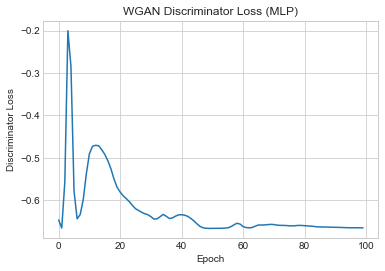

In [191]:
import numpy as np, _pickle as cPickle, editdistance, seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(wgan_discriminator_losses)
plt.title("WGAN Discriminator Loss (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.show()


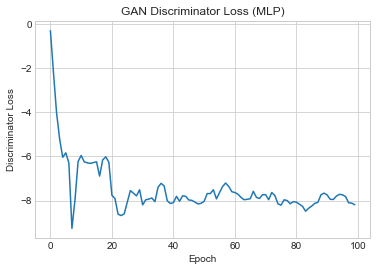

In [195]:
import matplotlib.pyplot as plt
plt.plot(gan_discriminator_losses)
plt.title("GAN Discriminator Loss (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.show()


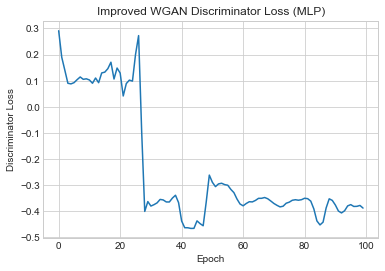

In [186]:
import matplotlib.pyplot as plt
plt.plot(improved_wgan_discriminator_losses)
plt.title("Improved WGAN Discriminator Loss (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.mean(wgan_generator_losses,axis=1))
plt.ylabel('some numbers')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.mean(wgan_discriminator_losses,axis=(1,2)))
plt.ylabel('some numbers')
plt.show()


In [196]:
class DCGAN(GAN):
    def make_generator(self):
        """Creates a generator model that takes a 100-dimensional noise vector as a "seed", and outputs images
        of size 28x28x1."""
        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=self.noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8)) 
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        return model

    def make_discriminator(self):
        """Creates a discriminator model that takes an image as input and outputs a single value, representing whether
        the input is real or generated. Unlike normal GANs, the output is not sigmoid and does not represent a probability!
        Instead, the output should be as large and negative as possible for generated inputs and as large and positive
        as possible for real inputs.
        Note that the improved WGAN paper suggests that BatchNormalization should not be used in the discriminator."""
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        return model

In [113]:
dcgan = DCGAN('improved_wgan')

GAN Type: improved_wgan
Optimizer: Adam
Loss: Wasserstein
Critics Ratio: 5
Gradient Penalty Applied


In [114]:
dcgan.train(2000, batch_size=BATCH_SIZE, save_interval=1)

Epoch:  0
Number of batches:  546


KeyboardInterrupt: 